In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pysta
import stc

import os

%load_ext autoreload
%autoreload 2

In [2]:
def load_sta_stat(dataset_name, folder_name="data", tap = 8):     
#     stim, spike_train, info = pysta.load_data(dataset_name, folder_name)

    folder_name = "{}_tap{}_sta".format(dataset_name, tap)
    sta_stat = pd.read_csv(os.path.join(folder_name, "stat_more.csv"))

    # subtract center from min,max
    sta_stat["min"] -= 0.5
    sta_stat["max"] -= 0.5

    sta_stat["peak_diff"] = sta_stat["max"] - sta_stat["min"] 

    # calc polarity
    pos = np.abs(sta_stat["max"])
    neg = np.abs(sta_stat["min"])

    #sta_result["polarity"] = (pos - neg) / np.sqrt(pos) / np.sqrt(neg)
    # sta_result["polarity"] = (pos - neg) / np.minimum(pos, neg)
    sta_stat["polarity"] = np.maximum(pos, neg) / np.minimum(pos, neg) * np.sign(pos-neg)

    # calc d_prime
    sta_stat["PSNR"] = (sta_stat["max"] - sta_stat["min"]) / sta_stat["sigma"]


    return sta_stat
    
sta_stat1 = load_sta_stat("20180618")
sta_stat1["dataset"] = "20180618"
sta_stat2 = load_sta_stat("20180621")
sta_stat2["dataset"] = "20180621"
sta_stat3 = load_sta_stat("20180626")
sta_stat3["dataset"] = "20180626"
# sta_stat4 = load_sta_stat("20180828")
# sta_stat4["dataset"] = "20180828"

# combine all patches 
# sta_stat = pd.concat([sta_stat1, sta_stat2, sta_stat3, sta_stat4])
sta_stat = pd.concat([sta_stat1, sta_stat2, sta_stat3])

print("total = ", len(sta_stat))
print(sta_stat["cell_type"].value_counts())
print(sta_stat["cell_type"].value_counts() / len(sta_stat))

total =  389
OFF        169
unknown    129
ON          91
Name: cell_type, dtype: int64
OFF        0.434447
unknown    0.331620
ON         0.233933
Name: cell_type, dtype: float64


In [3]:
sta_stat

,channel_name,num_samples,num_spikes,max,max_time_bin,min,min_time_bin,sigma,peak_diff,polarity,PSNR,cell_type,dataset
0,12a,1332,1978,-0.320526,4,-0.790192,5,0.038540,0.469666,-2.465300,12.186541,OFF,20180618
1,12b,889,1228,-0.313518,5,-0.592020,4,0.029235,0.278502,-1.888312,9.526389,ON,20180618
2,12c,58,59,-0.322034,3,-0.745763,5,0.068445,0.423729,-2.315789,6.190784,unknown,20180618
3,13a,722,963,-0.390447,3,-0.760125,5,0.033203,0.369678,-1.946809,11.134041,OFF,20180618
4,13b,383,415,-0.253012,5,-0.828916,4,0.034440,0.575904,-3.276190,16.721866,ON,20180618
...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,86c,526,705,-0.296454,5,-0.573050,4,0.027016,0.276596,-1.933014,10.238226,ON,20180626
152,86d,149,151,-0.271523,5,-0.675497,3,0.046548,0.403974,-2.487805,8.678597,ON,20180626
153,87a,3872,9120,-0.283882,4,-0.886513,5,0.027801,0.602632,-3.122827,21.676952,OFF,20180626
154,87b,3512,3797,-0.255201,5,-0.576508,3,0.019283,0.321306,-2.259030,16.662341,ON,20180626


In [4]:
x_data = np.log10(sta_stat["num_spikes"])
y_data = np.log10(sta_stat['sigma']**2)

# correlation coeff
rho = np.corrcoef(x_data, y_data)[0,1]
print(rho)

-0.8465567506146641


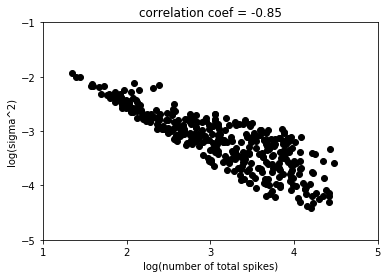

In [5]:
plt.scatter(x_data, y_data, marker='o', color='k')
# plt.xlabel('log(number of samples)')
plt.xlabel('log(number of total spikes)')
plt.ylabel('log(sigma^2)')

plt.title('correlation coef = {:.2f}'.format(rho))

plt.xlim([1, 5])
plt.xticks([1, 2, 3, 4, 5])
plt.ylim([-5, -1])
plt.yticks([-5, -4, -3, -2, -1])

# ax.set_xticklabels(["10^1","10^2","10^3","10^4","10^5"])

plt.savefig("figure/combined_n_vs_sig.pdf")
plt.savefig("figure/combined_n_vs_sig.png")

[-0.59693156 -1.31231239]
[[ 0.00036403 -0.00112758]
 [-0.00112758  0.0036868 ]]


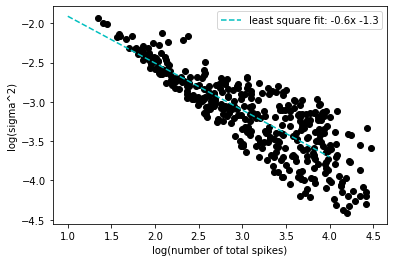

In [6]:
# fit to ax + b
# plt.figure(figsize=(8,6))
plt.scatter(x_data, y_data, marker='o', color='k')
# plt.xlabel('log(number of samples)')
plt.xlabel('log(number of total spikes)')
plt.ylabel('log(sigma^2)')

from scipy import optimize

def fit_func(x, a, b):
    return a * x + b

params, params_covariance = optimize.curve_fit(fit_func, x_data, y_data,
                                               p0=[-1, 0])

# def fit_func(x, b):
#     return -1 * x + b
# params, params_covariance = optimize.curve_fit(fit_func, x_data, y_data,
#                                                p0=[0])
print(params)
print(params_covariance)

x = np.linspace(1,4, 40)
plt.plot(x, fit_func(x, *params), 'c--', label='least square fit: {:.1f}x {:.1f}'.format(*params))
# plt.plot(x, fit_func(x, *params), 'k--', label='least square fit: -x {:.1f}'.format(*params))

plt.legend()

plt.savefig("figure/combined_n_vs_sig_fit.pdf")
plt.savefig("figure/combined_n_vs_sig_fit.png")

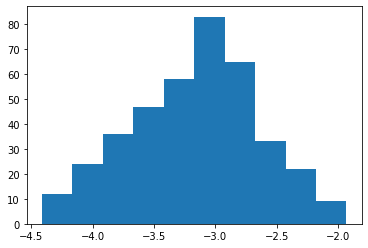

In [7]:
# select x by quantizing sigma and take minimum of x
# y_bins = np.linspace(-2.3, -0.8, 30)
# plt.hist(y_data, y_bins)
y_bins = np.linspace(-4.5, -1.5, 30)
plt.hist(y_data)

# fit selected samples to a x + b
x_selected = list()
y_selected = list()
idx_selected = list()

for i in range(len(y_bins)-1):
    idx = np.logical_and(y_data >= y_bins[i], y_data < y_bins[i+1])
    cnt = np.sum(idx)
    
    if cnt >0:
        xs = np.array(x_data[idx])
        ys = np.array(y_data[idx])

        # take min of x
        min_x = np.min(xs)        
        arg_min_x = np.argmin(xs)
        
        x_selected.append(min_x)
        y_selected.append(ys[arg_min_x])        
#         print(np.where(idx)[0], arg_min_x)
        idx_selected.append(np.where(idx)[0][arg_min_x])

x_selected = np.array(x_selected)
y_selected = np.array(y_selected)

-0.9852803733493424


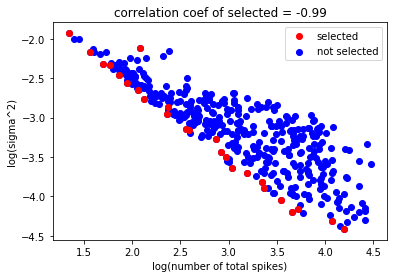

In [8]:
# cross correlation
rho_selected = np.corrcoef(x_selected, y_selected)[0,1]
print(rho_selected)

plt.scatter(x_data, y_data, color='b', label='not selected')
plt.plot(x_selected, y_selected, 'ro', label='selected')
plt.legend()

plt.xlabel('log(number of total spikes)')
# plt.xlabel('log(number of samples)')
plt.ylabel('log(sigma^2)')

plt.title('correlation coef of selected = {:.2f}'.format(rho_selected))

plt.savefig("figure/combined_n_vs_sig_selected.pdf")
plt.savefig("figure/combined_n_vs_sig_selected.png")

[-0.91988017 -0.71817452]
[[ 0.00110747 -0.00297866]
 [-0.00297866  0.00871236]]


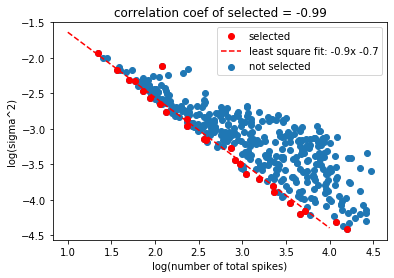

In [9]:
# fit selected samples to ax+b
def fit_func(x, a, b):
    return a * x + b

params, params_covariance = optimize.curve_fit(fit_func, x_selected, y_selected,
                                               p0=[-1, 0])
# def fit_func(x, b):
#     return - x + b

# params, params_covariance = optimize.curve_fit(fit_func, x_selected, y_selected,
#                                                p0=[0])

print(params)
print(params_covariance)


# plt.figure(figsize=(8,6))
plt.scatter(x_data, y_data, label='not selected')
plt.plot(x_selected, y_selected, 'ro', label='selected')

x = np.linspace(1,4, 40)
plt.plot(x, fit_func(x, *params), 'r--', label='least square fit: {:.1f}x {:.1f}'.format(*params))

plt.xlabel('log(number of total spikes)')
# plt.xlabel('log(number of samples)')
plt.ylabel('log(sigma^2)')
plt.legend()


plt.title('correlation coef of selected = {:.2f}'.format(rho_selected))

plt.savefig("figure/combined_n_vs_sig_fit_selected.pdf")
plt.savefig("figure/combined_n_vs_sig_fit_selected.png")

-0.3343533272550647


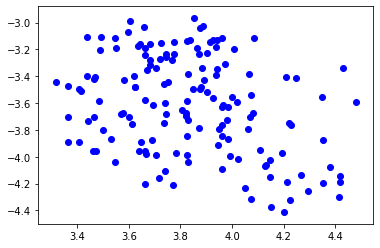

In [10]:
# plot for enough samples

spike_per_dim = 4 # hyper parameter that I get to choose

idx_enough_samples = sta_stat["num_samples"] >= 512*spike_per_dim
x_data = np.log10(sta_stat.loc[idx_enough_samples,"num_spikes"])
y_data = np.log10(sta_stat.loc[idx_enough_samples,'sigma']**2)

# correlation coeff
rho = np.corrcoef(x_data, y_data)[0,1]
print(rho)

plt.scatter(x_data, y_data, color='b', label='not selected')


In [11]:
# helper function to plot histograms of a column by cell_type
def plot_histogram_by_cell_type(clusters, col_name, alpha=0.5, separate_figure=False, XLIM=None):
    if separate_figure:
        plt.figure()
        
        
    idx_on = clusters["cell_type"] == "OFF"
    clusters.loc[idx_on, col_name].hist(alpha=alpha, color='b', label='OFF')
    
    if XLIM is not None:
        plt.xlim(XLIM)

    if separate_figure:
        plt.xlabel(col_name + " (OFF)")
        plt.ylabel("count")
        plt.show()    
    
    if separate_figure:
        plt.figure()
        
        
    idx_on = clusters["cell_type"] == "ON"
    clusters.loc[idx_on, col_name].hist(alpha=alpha, color='r', label='ON')
    
    if XLIM is not None:
        plt.xlim(XLIM)
    
    if separate_figure:
        plt.xlabel(col_name + " (ON)")
        plt.ylabel("count")
        plt.show()
        
    if separate_figure:
        plt.figure()

        
    idx_unknown = clusters["cell_type"] == "unknown"
    clusters.loc[idx_unknown, col_name].hist(alpha=alpha, color='k', label='unknown')
    
    if XLIM is not None:
        plt.xlim(XLIM)

    if separate_figure:
        plt.xlabel(col_name + " (unknown)")
        plt.ylabel("count")
        plt.show()
    else: # plot once
        plt.xlabel(col_name)
        plt.ylabel("count")
        plt.legend()

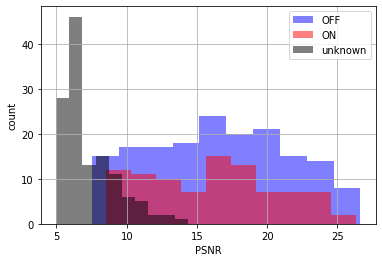

In [12]:
plot_histogram_by_cell_type(sta_stat, "PSNR", alpha=0.5)

plt.savefig("figure/combined_PSNR.pdf")
plt.savefig("figure/combined_PSNR.png")

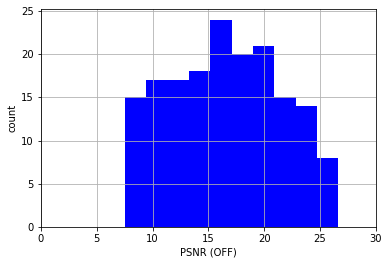

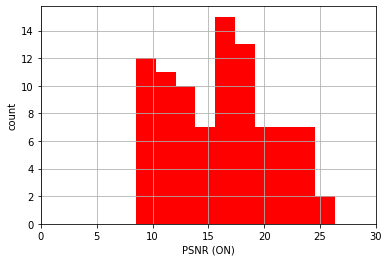

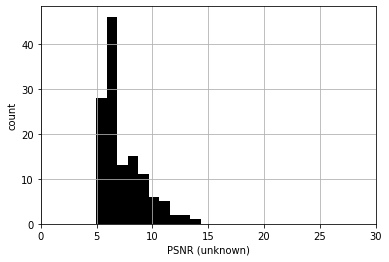

In [13]:
plot_histogram_by_cell_type(sta_stat, "PSNR", alpha=1, separate_figure=True, XLIM=[0,30])

# plt.savefig("figure/combined_PSNR_each.pdf")
# plt.savefig("figure/combined_PSNR_each.png")

Text(0, 0.5, 'number of spikes')

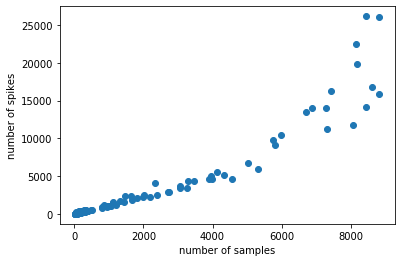

In [14]:
idx_unknown = sta_stat["cell_type"]=="unknown"
sta_stat_unknown = sta_stat.loc[idx_unknown]

plt.scatter(sta_stat_unknown["num_samples"], sta_stat_unknown["num_spikes"])
plt.xlabel('number of samples')
plt.ylabel('number of spikes')

## load clustering results

In [15]:
def load_clustering(dataset_name, tap=8, dim=3):

    folder_name = "{}_tap{}_stc_classic_cluster_dim{}".format(dataset_name, tap, dim)
    filename = os.path.join(folder_name, "clusters_combined.csv")

    return pd.read_csv(filename)

# dim = 2
dim = 3

cluster1 = load_clustering("20180618", dim=dim)
cluster1["dataset"] = "20180618"
cluster2 = load_clustering("20180621", dim=dim)
cluster2["dataset"] = "20180621"
cluster3 = load_clustering("20180626", dim=dim)
cluster3["dataset"] = "20180626"
# cluster4 = load_clustering("20180828")
# cluster4["dataset"] = "20180828"


# combine all patches 
# cluster = pd.concat([cluster1, cluster2, cluster3, cluster4])
cluster = pd.concat([cluster1, cluster2, cluster3])

print("total = ", len(cluster))
print(cluster["cell_type"].value_counts())
print(cluster["cell_type"].value_counts() / len(sta_stat))

total =  389
OFF        169
unknown    129
ON          91
Name: cell_type, dtype: int64
OFF        0.434447
unknown    0.331620
ON         0.233933
Name: cell_type, dtype: float64


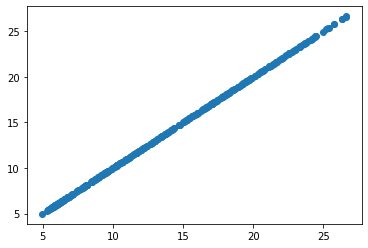

In [16]:
# sanity check
plt.scatter(sta_stat["PSNR"], cluster["PSNR"])

In [17]:
# with enough samples
spike_per_dim = 4 # hyper parameter that I get to choose

idx_enough_samples = cluster["number_of_spikes"]>512*spike_per_dim
cluster_with_enough_samples = cluster.loc[idx_enough_samples]

print("total = ", len(cluster_with_enough_samples))
print(cluster_with_enough_samples["cell_type"].value_counts())
print(cluster_with_enough_samples["cell_type"].value_counts() / len(sta_stat))


total =  171
OFF        84
ON         48
unknown    39
Name: cell_type, dtype: int64
OFF        0.215938
ON         0.123393
unknown    0.100257
Name: cell_type, dtype: float64


In [18]:
cluster_with_enough_samples

,channel_name,PSNR,weight1,weight2,inner_product,PSNR1,PSNR2,max_weight,number_of_samples,number_of_spikes,eig1,eig2,eig3,cell_type,dataset
7,14a,25.775064,0.496649,0.503351,-0.039999,17.368013,17.958545,0.503351,2835,5973,0.620785,0.571746,0.571746,ON,20180618
9,17a,8.452868,0.516360,0.483640,-0.243797,6.274501,5.573316,0.516360,5318,5929,0.436700,0.434049,0.434049,unknown,20180618
10,17b,8.515376,0.510076,0.489924,-0.284236,6.354987,7.666436,0.510076,2382,2553,0.570595,0.559954,0.559954,unknown,20180618
21,23a,22.562123,0.485247,0.514753,0.090527,16.158564,17.770326,0.514753,4033,12115,0.604328,0.517577,0.517577,OFF,20180618
22,23b,11.990694,0.483836,0.516164,-0.201128,8.734075,6.737893,0.516164,2753,4619,0.700543,0.608037,0.608037,ON,20180618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,82b,15.507029,0.530612,0.469388,0.002175,10.626819,11.373966,0.530612,1617,2842,0.798825,0.714066,0.714066,OFF,20180626
144,83a,20.351671,0.502418,0.497582,-0.081769,11.820078,14.292448,0.502418,6618,17646,0.493440,0.462766,0.462766,OFF,20180626
149,86a,19.576154,0.544832,0.455168,0.298754,15.706884,15.301827,0.544832,1461,3186,0.952703,0.766365,0.766365,ON,20180626
153,87a,21.676952,0.499483,0.500517,0.078728,15.288808,17.012831,0.500517,3872,9120,0.590420,0.517161,0.517161,OFF,20180626


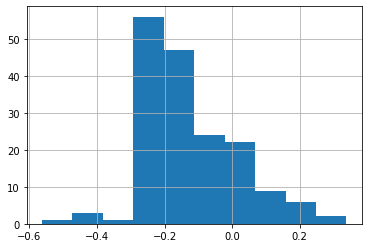

In [19]:
cluster_with_enough_samples["inner_product"].hist()

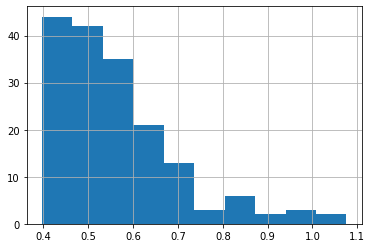

In [20]:
cluster_with_enough_samples["eig1"].hist()

In [21]:
idx_on = cluster_with_enough_samples["cell_type"] == "ON"
idx_off = cluster_with_enough_samples["cell_type"] == "OFF"
idx_unknown = cluster_with_enough_samples["cell_type"] == "unknown"

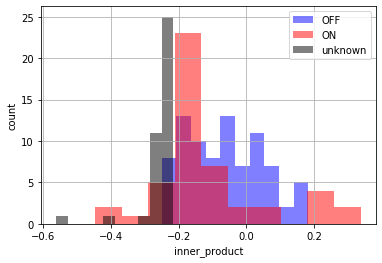

In [22]:
plot_histogram_by_cell_type(cluster_with_enough_samples, "inner_product")
plt.savefig('figure/cluster_inner_product_hist_dim{}_spd{}.pdf'.format(dim,spike_per_dim))
plt.savefig('figure/cluster_inner_product_hist_dim{}_spd{}.png'.format(dim,spike_per_dim))

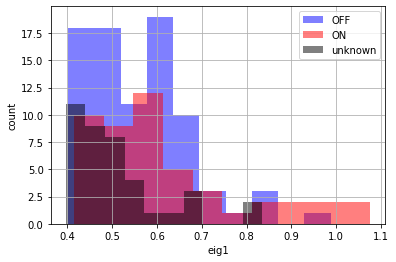

In [23]:
plot_histogram_by_cell_type(cluster_with_enough_samples, "eig1")

Text(0, 0.5, '1st eigenvalue')

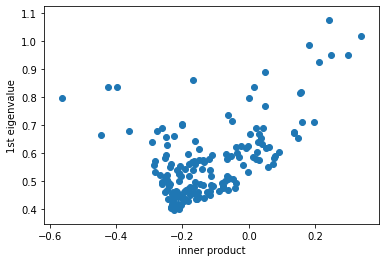

In [24]:
plt.scatter(cluster_with_enough_samples["inner_product"], cluster_with_enough_samples["eig1"])
plt.xlabel('inner product')
plt.ylabel('1st eigenvalue')

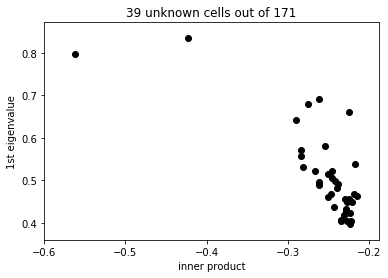

In [25]:
plt.scatter(cluster_with_enough_samples.loc[idx_unknown,"inner_product"], cluster_with_enough_samples.loc[idx_unknown,"eig1"], c="k")
plt.xlabel('inner product')
plt.ylabel('1st eigenvalue')

plt.xticks([-0.6, -0.5, -0.4, -0.3, -0.2])
plt.title ("{} unknown cells out of {}".format(np.sum(idx_unknown),len(cluster_with_enough_samples)))
plt.savefig('figure/cluster_inner_product_vs_eig1_unknown_dim{}_spd{}.pdf'.format(dim,spike_per_dim))
plt.savefig('figure/cluster_inner_product_vs_eig1_unknown_dim{}_spd{}.png'.format(dim,spike_per_dim))

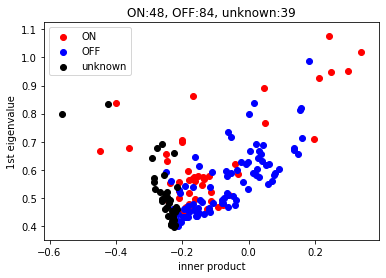

In [26]:
plt.scatter(cluster_with_enough_samples.loc[idx_on,"inner_product"], cluster_with_enough_samples.loc[idx_on,"eig1"], c="r")
plt.scatter(cluster_with_enough_samples.loc[idx_off,"inner_product"], cluster_with_enough_samples.loc[idx_off,"eig1"], c="b")
plt.scatter(cluster_with_enough_samples.loc[idx_unknown,"inner_product"], cluster_with_enough_samples.loc[idx_unknown,"eig1"], c="k")
plt.xlabel('inner product')
plt.ylabel('1st eigenvalue')

plt.title ("ON:{}, OFF:{}, unknown:{}".format(np.sum(idx_on),np.sum(idx_off),np.sum(idx_unknown)))

plt.legend(["ON", "OFF", "unknown"])

plt.savefig('figure/cluster_inner_product_vs_eig1_dim{}_spd{}.pdf'.format(dim,spike_per_dim))
plt.savefig('figure/cluster_inner_product_vs_eig1_dim{}_spd{}.png'.format(dim,spike_per_dim))

In [27]:
cluster_with_enough_samples.sort_values('inner_product').head(30)#.sort_values("dataset")
# cluster_with_enough_samples.sort_values(['dataset','inner_product'])

,channel_name,PSNR,weight1,weight2,inner_product,PSNR1,PSNR2,max_weight,number_of_samples,number_of_spikes,eig1,eig2,eig3,cell_type,dataset
64,36c,10.318830,0.476680,0.523320,-0.562238,19.182946,19.189995,0.523320,2337,4098,0.798256,0.620102,0.620102,unknown,20180626
44,35a,13.477084,0.462932,0.537068,-0.447045,24.013682,26.919923,0.537068,3534,9638,0.665520,0.552200,0.552200,ON,20180618
25,22b,6.267735,0.550637,0.449363,-0.423474,13.648889,14.567316,0.550637,1649,2413,0.835159,0.782430,0.782430,unknown,20180626
24,22a,17.556724,0.407099,0.592901,-0.398691,13.791455,18.973007,0.592901,1803,2860,0.838246,0.704459,0.704459,ON,20180626
109,85b,11.494061,0.500585,0.499415,-0.361110,14.563942,13.746352,0.500585,2563,4002,0.678136,0.597015,0.597015,ON,20180621
47,37b,6.924673,0.497235,0.502765,-0.290711,6.414339,5.863334,0.502765,1989,2247,0.641578,0.611518,0.611518,unknown,20180621
65,46b,6.176081,0.497950,0.502050,-0.284564,6.201839,6.391275,0.502050,2195,2306,0.558057,0.554718,0.554718,unknown,20180618
10,17b,8.515376,0.510076,0.489924,-0.284236,6.354987,7.666436,0.510076,2382,2553,0.570595,0.559954,0.559954,unknown,20180618
104,77a,8.146201,0.496313,0.503687,-0.281493,5.695393,6.298583,0.503687,2712,2879,0.531850,0.520963,0.520963,unknown,20180618
107,61b,9.815396,0.498896,0.501104,-0.275768,6.818353,5.623206,0.501104,1812,2148,0.679410,0.648867,0.648867,unknown,20180626


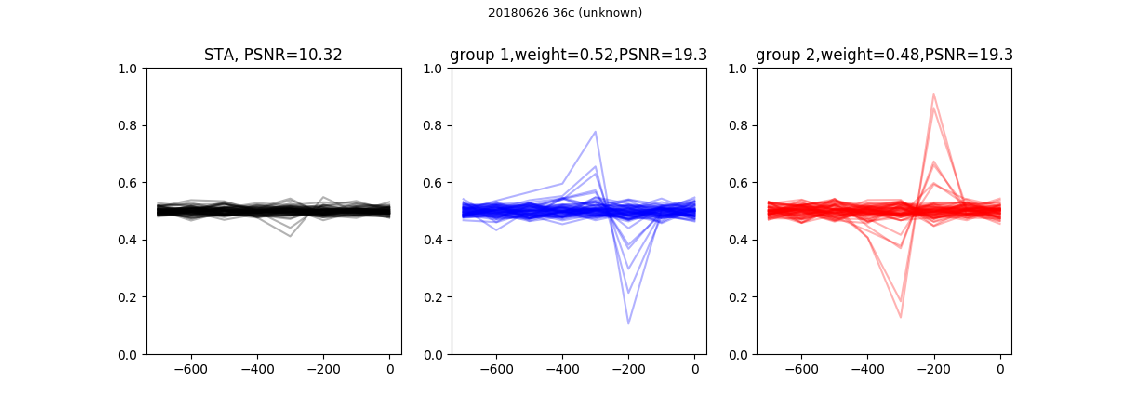

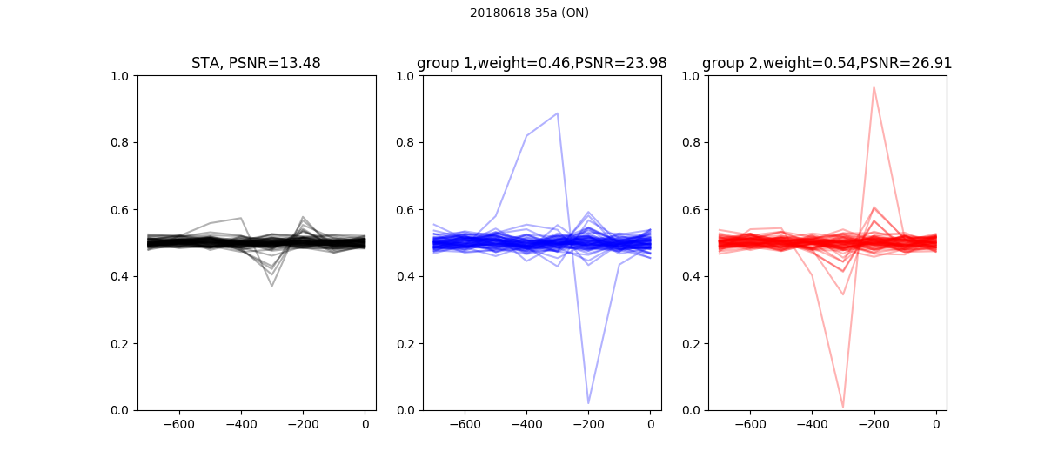

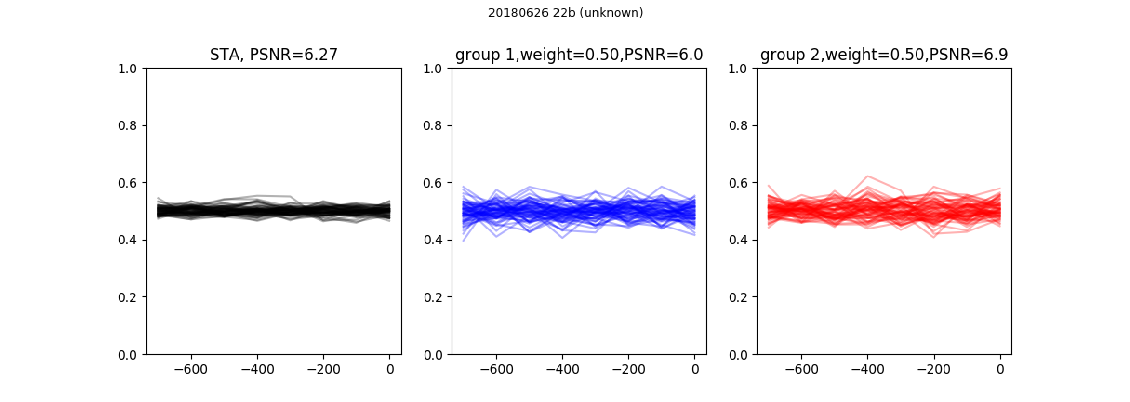

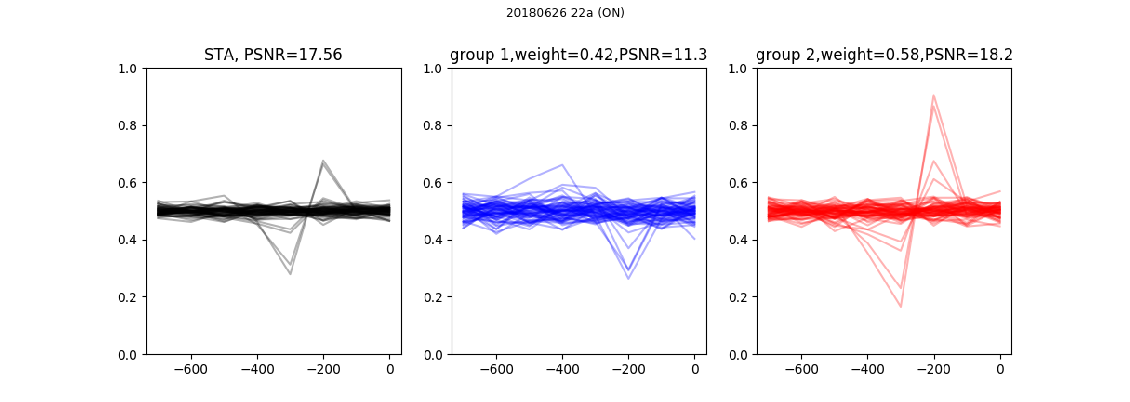

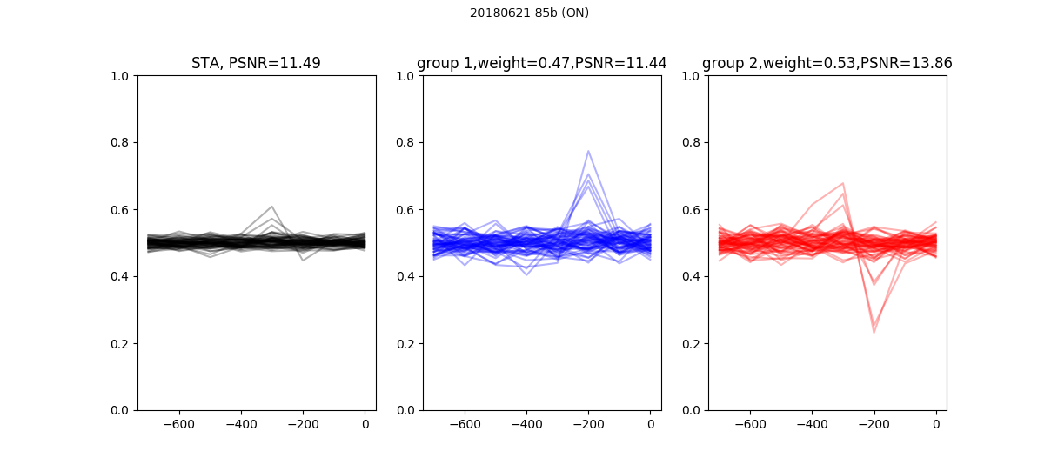

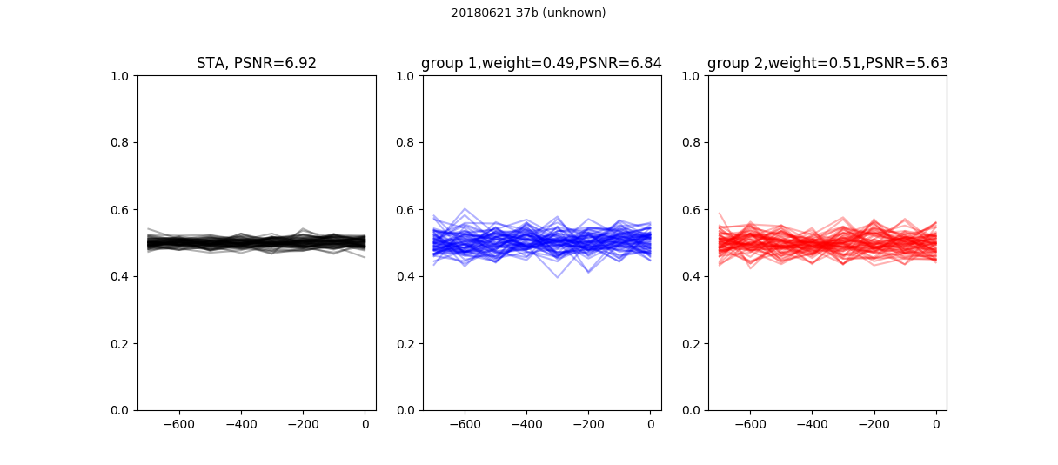

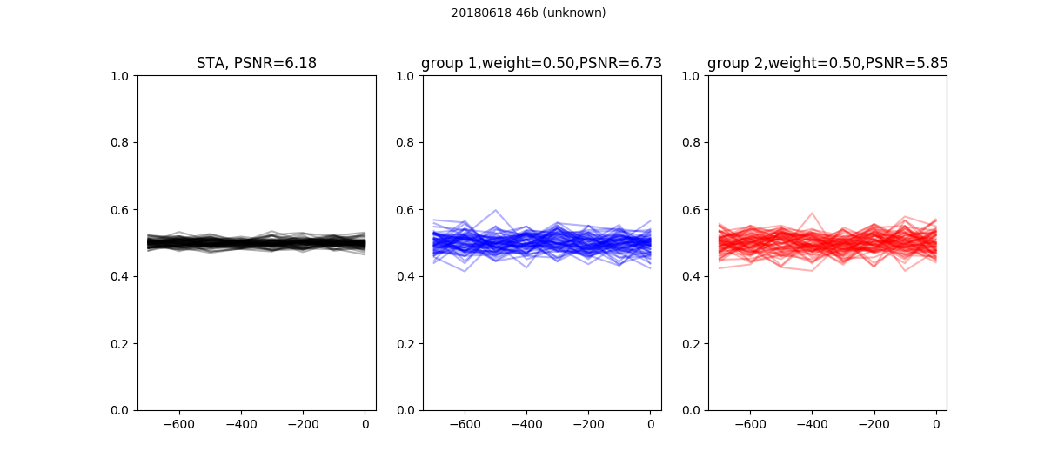

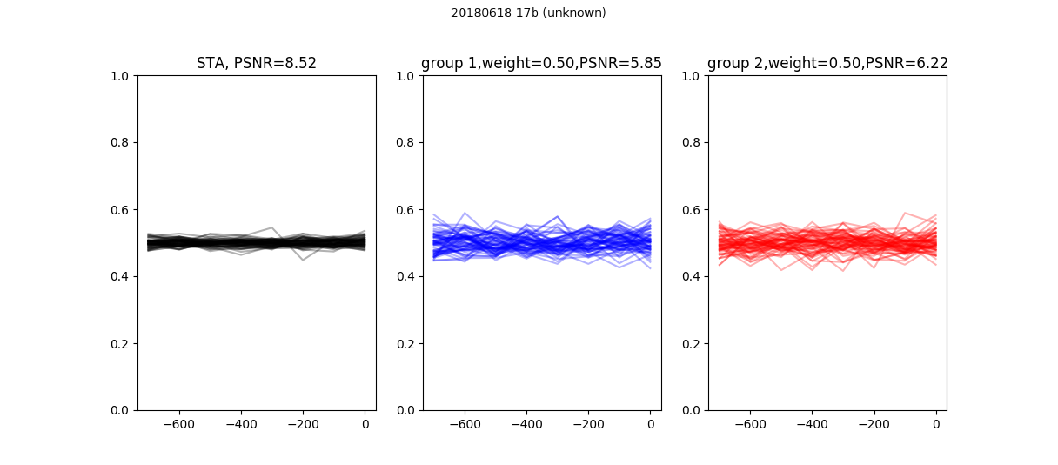

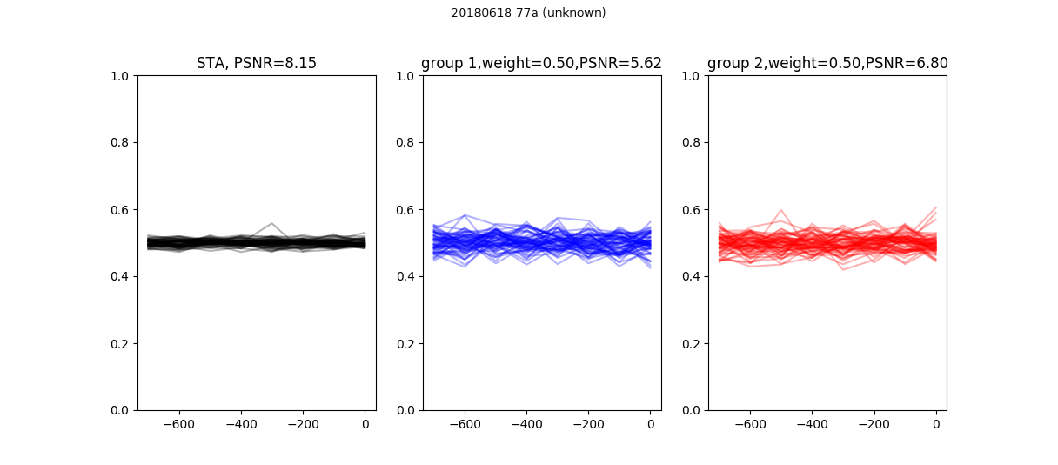

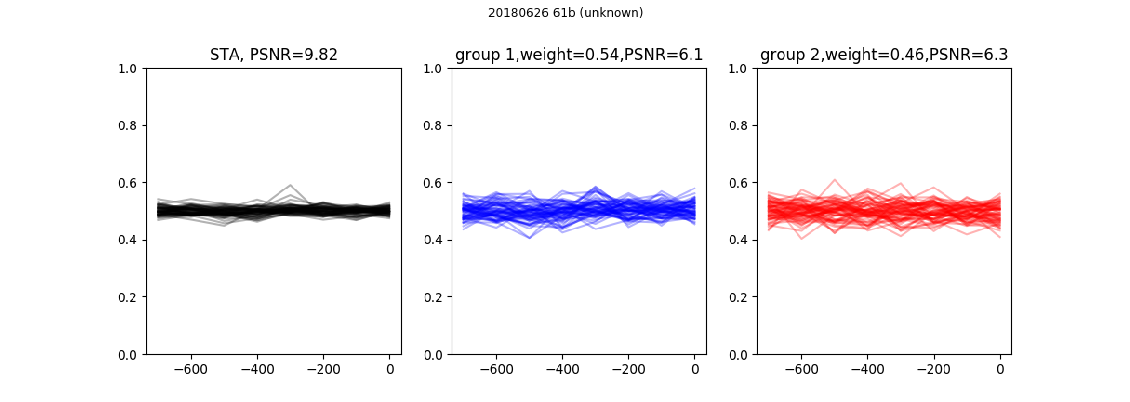

In [32]:
# sort by inner product and plot

cluster_sorted_by_inner_product = cluster_with_enough_samples.sort_values('inner_product').head(30)#.sort_values("dataset")

def plot_examples(cluster_sorted, filename, dim, num=10):
    for i in range(num):
        dataset_name = cluster_sorted.iloc[i]["dataset"]
        folder_name = "{}_tap8_stc_classic_cluster_dim2".format(dataset_name)
        channel_name = cluster_sorted.iloc[i]["channel_name"]
        cell_type = cluster_sorted.iloc[i]["cell_type"]

        plt.figure(figsize=(20,8))
        im1 = plt.imread(os.path.join(folder_name, "{}_d2_centers.png".format(channel_name)))
        plt.imshow(im1)
        plt.box('off')
        plt.axis('off')
        plt.title(dataset_name + " " + channel_name + " ({})".format(cell_type))
        plt.savefig("figure/{}_{}_dim{}.png".format(filename, i+1,dim))

        plt.show()
    
plot_examples(cluster_sorted_by_inner_product, "cluster_inner_product", dim=dim)


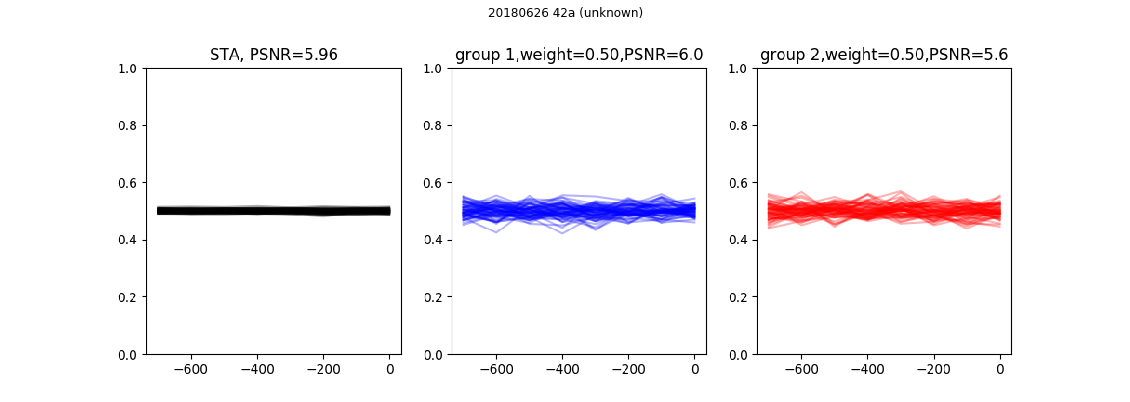

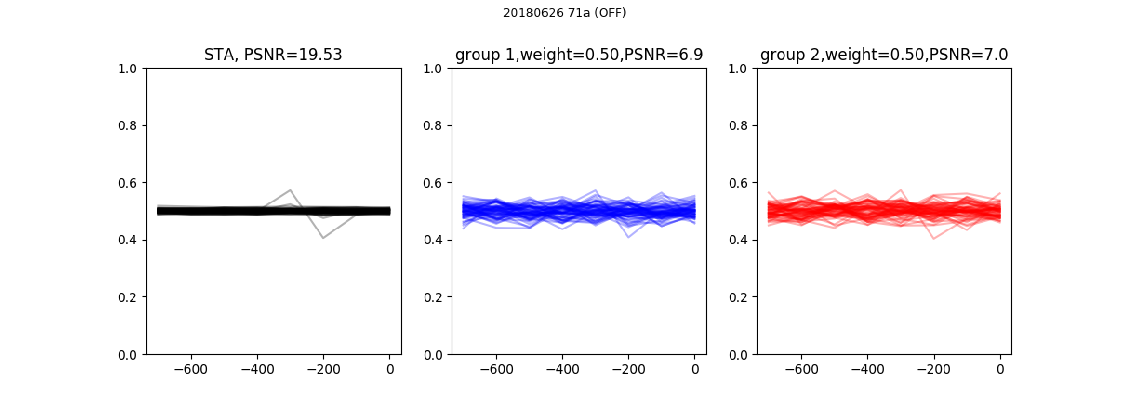

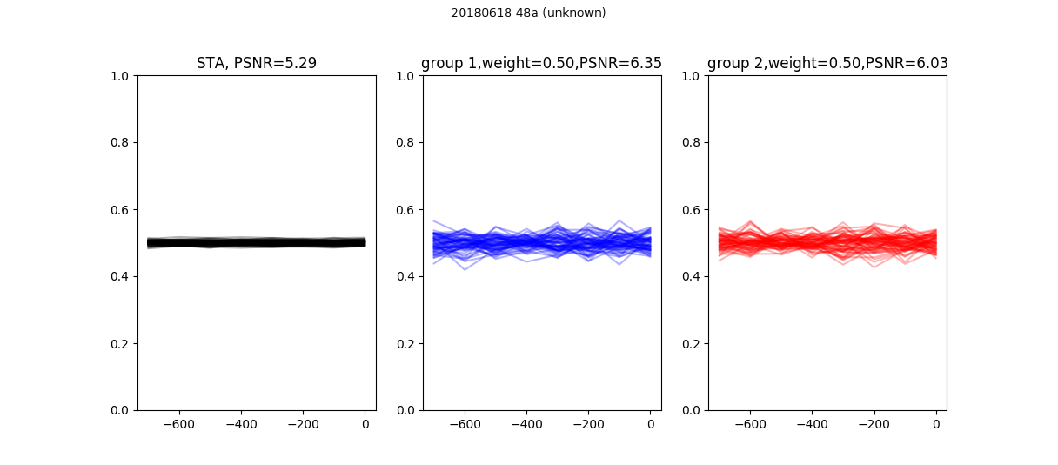

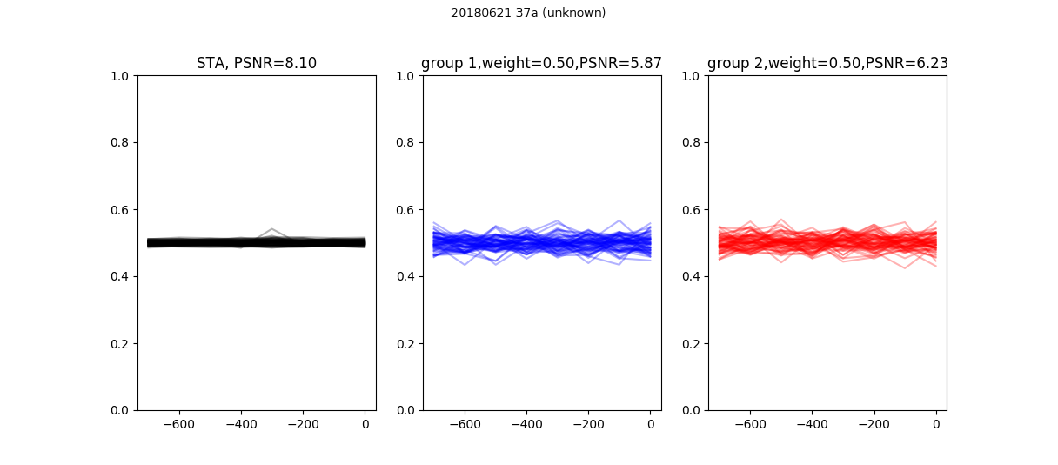

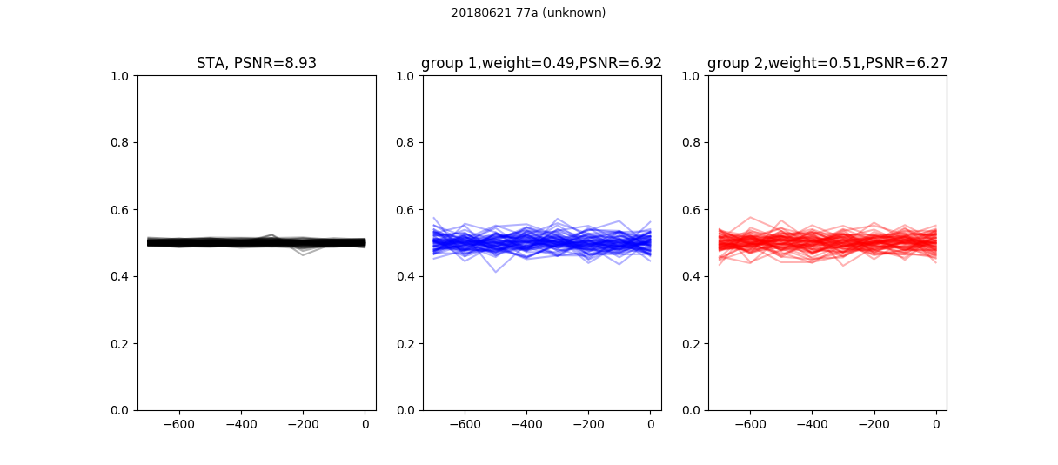

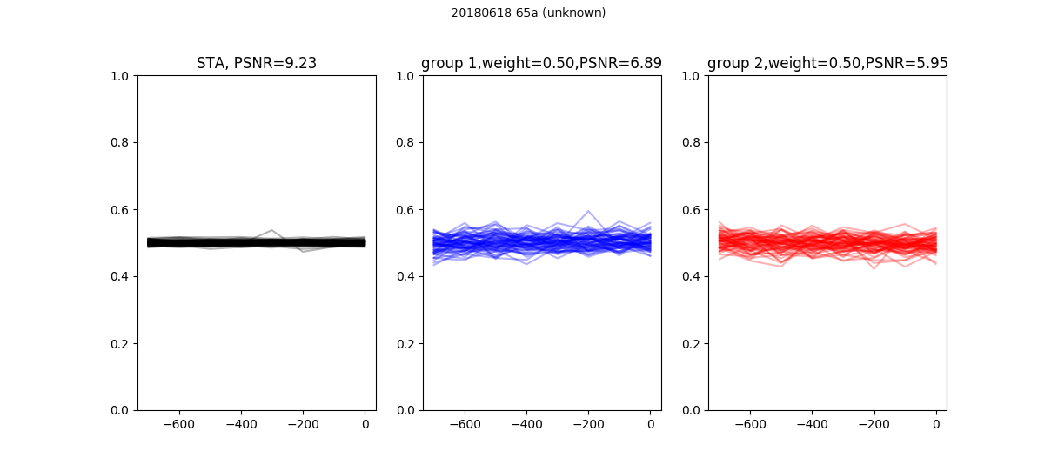

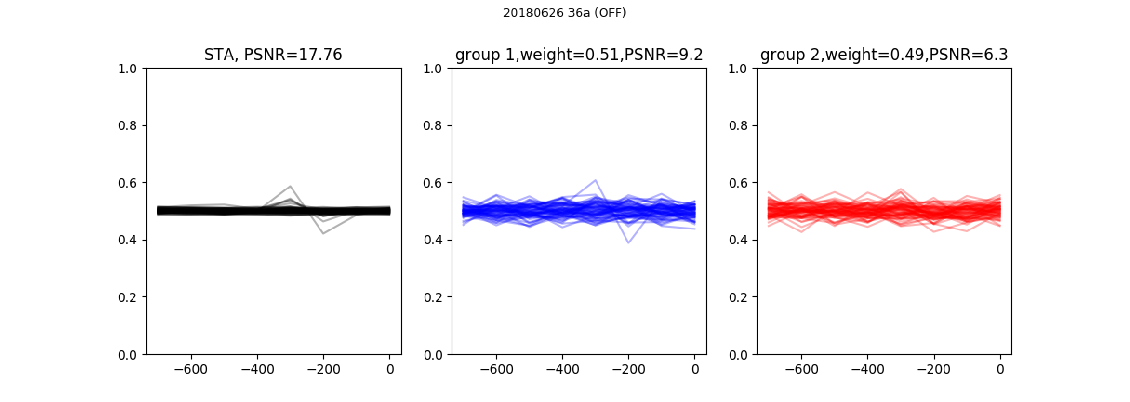

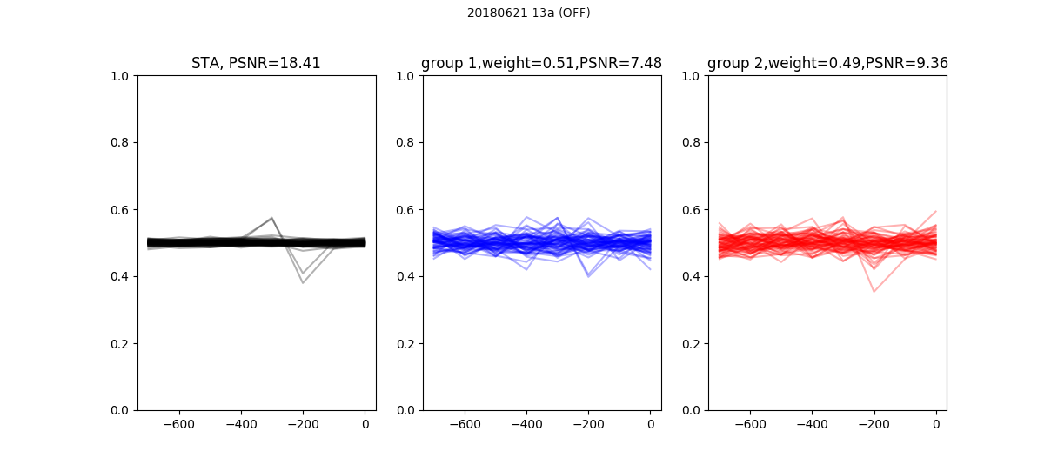

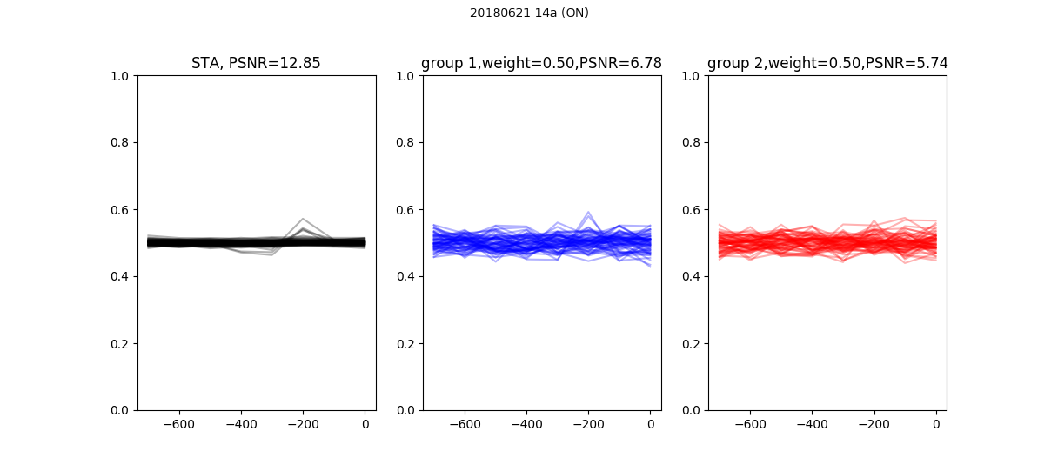

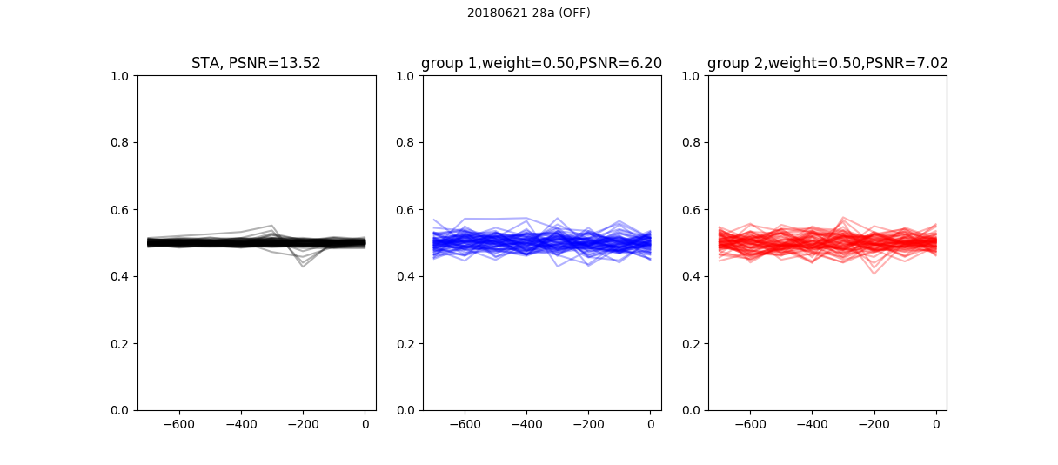

In [33]:
# sort by inner product and plot

cluster_sorted_by_eig1 = cluster_with_enough_samples.sort_values('eig1').head(30)#.sort_values("dataset")

plot_examples(cluster_sorted_by_eig1, "cluster_eig", dim=dim)


